In [ ]:
!pip install text_hammer
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import text_hammer as th
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.2
    Uninstalling beautifulsoup4-4.11.2:
      Successfully uninstalled beautifulsoup4-4.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.18 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


## Data Pre-**processing**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FF6126_Team10_data.csv to FF6126_Team10_data.csv


In [ ]:
df = pd.read_csv('FF6126_Team10_data.csv',encoding= "ISO-8859-1")
df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


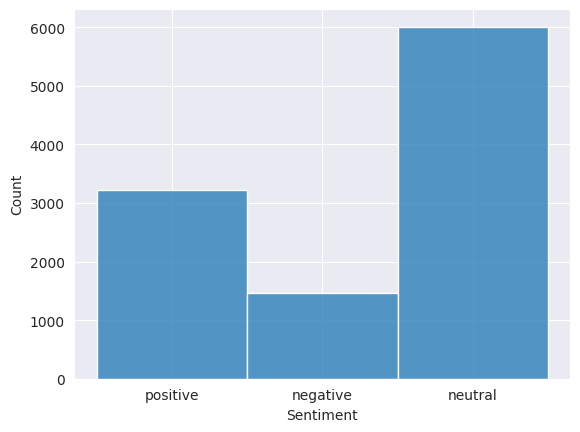

In [ ]:
import seaborn as sns
sns.set_style('darkgrid')
sns.histplot(x='Sentiment',data=df)
plt.show()

In [ ]:
df['len'] = list(map(lambda x: len(str(x).split(' ')),df['Sentence']))
df.head()

,Sentence,Sentiment,len
0,The GeoSolutions technology will leverage Bene...,positive,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,11
2,"For the last quarter of 2010 , Componenta 's n...",positive,39
3,According to the Finnish-Russian Chamber of Co...,neutral,20
4,The Swedish buyout firm has sold its remaining...,neutral,23


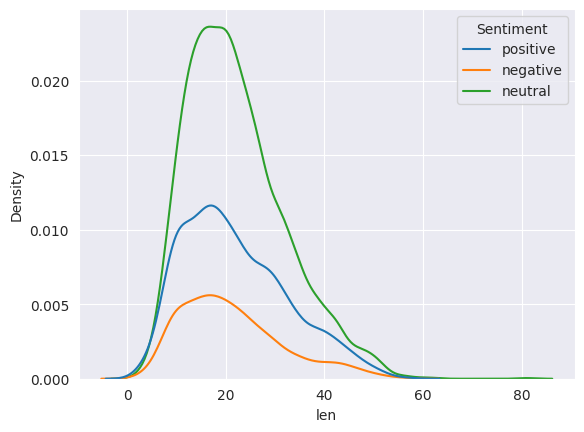

In [ ]:
sns.kdeplot(x='len',hue='Sentiment',data=df)
plt.show()

In [ ]:
mapdf = {'positive':0,'negative':1,'neutral':2}
df['Sentiment'] = list(map(lambda x:mapdf[x],df['Sentiment']))
df.head()

,Sentence,Sentiment,len
0,The GeoSolutions technology will leverage Bene...,0,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1,11
2,"For the last quarter of 2010 , Componenta 's n...",0,39
3,According to the Finnish-Russian Chamber of Co...,2,20
4,The Swedish buyout firm has sold its remaining...,2,23


In [ ]:
print(df['Sentiment'].corr(df['len']))

0.011804443334257564


Here as we are going to execute exactly the same procedures on both train and test data (such as removing punctuations and tokenizing using exactly the same library), we will choose to do this on both set of data at the same time in order to reduce the lenght of the program. We actually have the ability to seperately process data for train and test.

In [ ]:
sentences = df['Sentence'].copy()[:]
sentences = sentences.to_list()
sentences = list(map(lambda x: x.lower(),sentences))
sentences = list(map(lambda x: th.cont_exp(x),sentences))
sentences = list(map(lambda x: th.remove_emails(x),sentences))
sentences = list(map(lambda x: th.remove_emails(x),sentences))
sentences = list(map(lambda x: th.remove_html_tags(x),sentences))
sentences = list(map(lambda x: th.remove_stopwords(x),sentences))
sentences = list(map(lambda x: th.remove_special_chars(x),sentences))
sentences = list(map(lambda x: th.remove_accented_chars(x),sentences))
sentences = list(map(lambda x: th.make_base(x),sentences))

In [ ]:
sentences[:3]

['geosolutions technology leverage benefon global positioning system solution provide location base search technology community platform location relevant multimedia content new powerful commercial model',
 'esi low 150 250 bk real possibility',
 'quarter 2010 componenta net sale double eur131 m eur76 m period year early move zero pretax profit pretax loss eur7 m']

In [ ]:
import nltk
nltk.download('punkt')
pairs = []
for sent in tqdm(sentences):
    pairs.extend(nltk.word_tokenize(sent))
freq = nltk.FreqDist(pairs)
freq.most_common(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


  0%|          | 0/10688 [00:00<?, ?it/s]

[('eur', 2299),
 ('company', 1885),
 ('mn', 1244),
 ('say', 1169),
 ('sale', 1108),
 ('finnish', 1039),
 ('profit', 997),
 ('share', 950),
 ('million', 934),
 ('net', 912)]

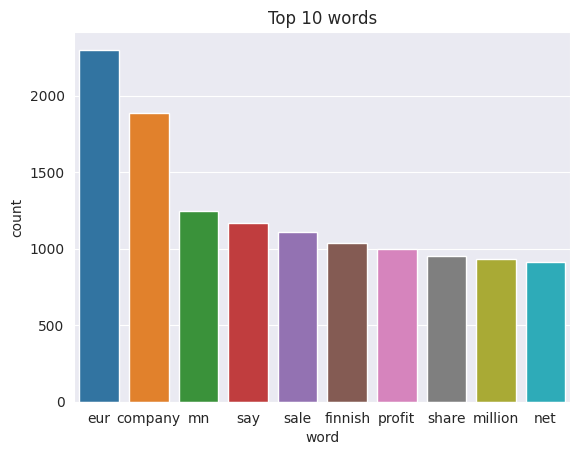

In [ ]:
tempdf = pd.DataFrame(freq.most_common(10),  columns=['word', 'count'])
sns.barplot(x='word',y='count',data=tempdf)
plt.title("Top 10 words")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
y = to_categorical(df['Sentiment'])
x = sentences.copy()
X_train,X_test, y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=42)

Tokenization

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 13000 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([pd.Series(X_train), pd.Series(X_test)], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=81,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 81, padding = 'post')

In [ ]:
print(X_train_pad.shape,X_test_pad.shape)

(7481, 81) (3207, 81)


# **Simple LSTM neural network**
Set up layers of the network

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Bidirectional,Embedding,Dropout

In [ ]:
lstm = Sequential()
lstm.add(Embedding(input_dim = num_words,
                          output_dim = 100,
                          input_length= X_train_pad.shape[1]))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(256,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=False)))
lstm.add(Dense(64,activation='tanh'))
lstm.add(Dense(32,activation='tanh'))
lstm.add(Dense(10,activation='tanh'))
lstm.add(Dense(3,activation='softmax'))

In [ ]:
lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 81, 100)           1300000   
                                                                 
 dropout (Dropout)           (None, 81, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 81, 256)          234496    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 81, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 81, 512)          1050624   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 81, 512)           0

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

Fit the train set to this network.

In [ ]:
lstm_history = lstm.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10
117/117 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.6539
Epoch 1: val_accuracy improved from -inf to 0.73558, saving model to ./model.h5
117/117 [==============================] - 214s 2s/step - loss: 0.7863 - accuracy: 0.6539 - val_loss: 0.6361 - val_accuracy: 0.7356
Epoch 2/10
117/117 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.8425
Epoch 2: val_accuracy improved from 0.73558 to 0.78516, saving model to ./model.h5
117/117 [==============================] - 200s 2s/step - loss: 0.4092 - accuracy: 0.8425 - val_loss: 0.5316 - val_accuracy: 0.7852
Epoch 3/10
117/117 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9103
Epoch 3: val_accuracy improved from 0.78516 to 0.79638, saving model to ./model.h5
117/117 [==============================] - 199s 2s/step - loss: 0.2410 - accuracy: 0.9103 - val_loss: 0.5821 - val_accuracy: 0.7964
Epoch 4/10
117/117 [==============================] - ETA: 0s - loss: 

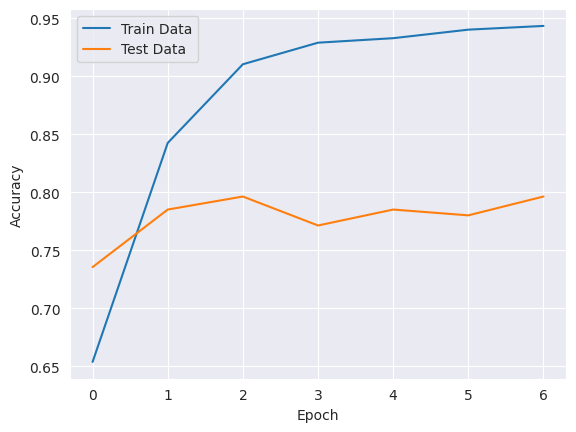

In [ ]:
plt.plot(lstm_history.history['accuracy'], label='Train Data')
plt.plot(lstm_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1])
plt.legend(loc='best')
plt.show()

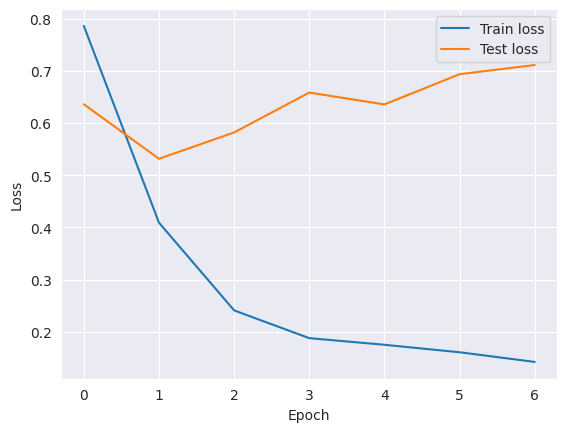

In [ ]:
plt.plot(lstm_history.history['loss'], label='Train loss')
plt.plot(lstm_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

Predict the test set and get accuracy result.

In [ ]:
from sklearn.metrics import classification_report
predictions = lstm.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

101/101 [==============================] - 27s 246ms/step
              precision    recall  f1-score   support

    positive       0.80      0.84      0.82       965
    negative       0.55      0.66      0.60       439
     neutral       0.87      0.81      0.84      1803

    accuracy                           0.80      3207
   macro avg       0.74      0.77      0.75      3207
weighted avg       0.81      0.80      0.80      3207



# **GLOVE embedding method + LSTM**
Download Pre-trained GloVe vector for embedding the padded sequence.

In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
glove_gensim.most_similar(positive=['king','woman'],negative=['man'],topn=1)

[('queen', 0.6713277101516724)]

In [ ]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tqdm(tokenizer.word_index.items()):
    if index < num_words: # since index starts with zero 
        try:
            gensim_weight_matrix[index] = glove_gensim[word]
        except:
            gensim_weight_matrix[index] = np.zeros(300)

  0%|          | 0/11716 [00:00<?, ?it/s]

In [ ]:
gensim_weight_matrix.shape

(13000, 300)

The rest are the same.

In [ ]:
glove = Sequential()
glove.add(Embedding(input_dim = num_words,
                          output_dim = 300,
                          input_length= X_train_pad.shape[1],
                          weights = [gensim_weight_matrix],
                          trainable = False))
glove.add(Dropout(0.2))
glove.add(Bidirectional(LSTM(128,return_sequences=True)))
glove.add(Dropout(0.2))
glove.add(Bidirectional(LSTM(256,return_sequences=True)))
glove.add(Dropout(0.2))
glove.add(Bidirectional(LSTM(128,return_sequences=False)))
glove.add(Dense(64,activation='tanh'))
glove.add(Dense(32,activation='tanh'))
glove.add(Dense(10,activation='tanh'))
glove.add(Dense(3,activation='softmax'))

In [ ]:
glove.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 81, 300)           3900000   
                                                                 
 dropout_6 (Dropout)         (None, 81, 300)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 81, 256)          439296    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 81, 256)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 81, 512)          1050624   
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 81, 512)          

In [ ]:
glove.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
glove_history = glove.fit(X_train_pad,y_train, epochs = 20, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.7983 - accuracy: 0.6474
Epoch 1: val_accuracy did not improve from 0.81852
117/117 [==============================] - 221s 2s/step - loss: 0.7983 - accuracy: 0.6474 - val_loss: 0.7337 - val_accuracy: 0.6757
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 0.6477 - accuracy: 0.7315
Epoch 2: val_accuracy did not improve from 0.81852
117/117 [==============================] - 228s 2s/step - loss: 0.6477 - accuracy: 0.7315 - val_loss: 0.6720 - val_accuracy: 0.7231
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.7637
Epoch 3: val_accuracy did not improve from 0.81852
117/117 [==============================] - 227s 2s/step - loss: 0.5749 - accuracy: 0.7637 - val_loss: 0.6330 - val_accuracy: 0.7449
Epoch 4/20
117/117 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.7941
Epoch 4: val_accuracy did not improve from 0.81852
117/117 [=======

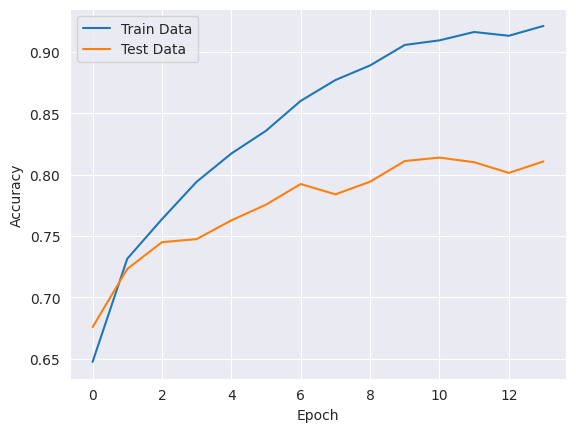

In [ ]:
plt.plot(glove_history.history['accuracy'], label='Train Data')
plt.plot(glove_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.98, 1])
plt.legend(loc='best')
plt.show()

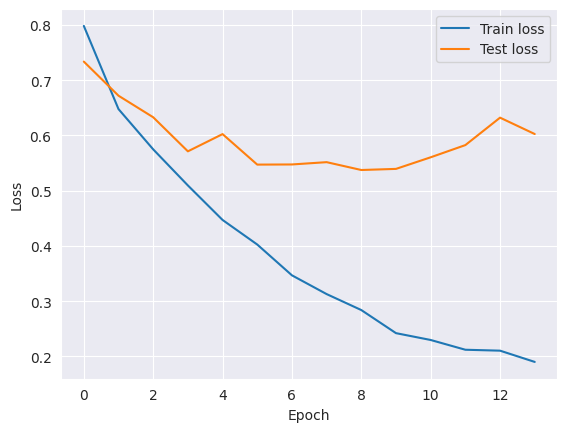

In [ ]:
plt.plot(glove_history.history['loss'], label='Train loss')
plt.plot(glove_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [ ]:
predictions = glove.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

101/101 [==============================] - 30s 279ms/step
              precision    recall  f1-score   support

    positive       0.81      0.85      0.83       965
    negative       0.56      0.64      0.60       439
     neutral       0.88      0.83      0.86      1803

    accuracy                           0.81      3207
   macro avg       0.75      0.77      0.76      3207
weighted avg       0.82      0.81      0.81      3207



# **Fasttext embedding + LSTM**
Download Fasttext vector.

In [ ]:
import gensim.downloader as api
glove_gensim1  = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
vector_size = 300
gensim_weight_matrix1 = np.zeros((num_words ,vector_size))
gensim_weight_matrix1.shape

for word, index in tqdm(tokenizer.word_index.items()):
    if index < num_words: # since index starts with zero 
        try:
            gensim_weight_matrix1[index] = glove_gensim1[word]
        except:
            gensim_weight_matrix1[index] = np.zeros(300)

  0%|          | 0/11716 [00:00<?, ?it/s]

In [ ]:
ftext = Sequential()
ftext.add(Embedding(input_dim = num_words,
                          output_dim = 300,
                          input_length= X_train_pad.shape[1],
                          weights = [gensim_weight_matrix1],
                          trainable = False))
ftext.add(Dropout(0.2))
ftext.add(Bidirectional(LSTM(128,return_sequences=True)))
ftext.add(Dropout(0.2))
ftext.add(Bidirectional(LSTM(256,return_sequences=True)))
ftext.add(Dropout(0.2))
ftext.add(Bidirectional(LSTM(128,return_sequences=False)))
ftext.add(Dense(64,activation='tanh'))
ftext.add(Dense(32,activation='tanh'))
ftext.add(Dense(10,activation='tanh'))
ftext.add(Dense(3,activation='softmax'))

In [ ]:
ftext.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 81, 300)           3900000   
                                                                 
 dropout_12 (Dropout)        (None, 81, 300)           0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 81, 256)          439296    
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 81, 256)           0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 81, 512)          1050624   
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 81, 512)          

In [ ]:
ftext.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
ftext_history = ftext.fit(X_train_pad,y_train, epochs = 20, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.8577 - accuracy: 0.6025
Epoch 1: val_accuracy did not improve from 0.81852
117/117 [==============================] - 250s 2s/step - loss: 0.8577 - accuracy: 0.6025 - val_loss: 0.7757 - val_accuracy: 0.6539
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.6643
Epoch 2: val_accuracy did not improve from 0.81852
117/117 [==============================] - 210s 2s/step - loss: 0.7462 - accuracy: 0.6643 - val_loss: 0.7128 - val_accuracy: 0.6913
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.6905
Epoch 3: val_accuracy did not improve from 0.81852
117/117 [==============================] - 210s 2s/step - loss: 0.6932 - accuracy: 0.6905 - val_loss: 0.6799 - val_accuracy: 0.7016
Epoch 4/20
117/117 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.7114
Epoch 4: val_accuracy did not improve from 0.81852
117/117 [=======

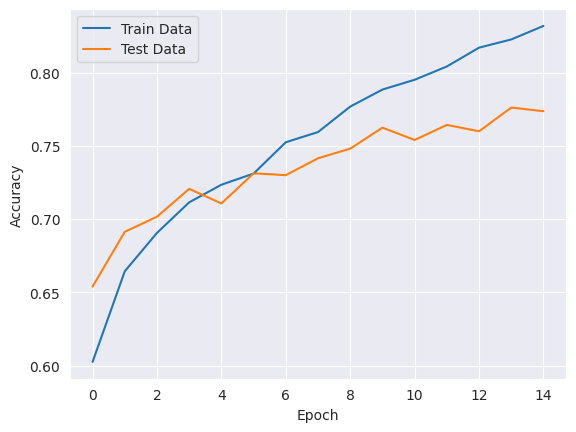

In [ ]:
plt.plot(ftext_history.history['accuracy'], label='Train Data')
plt.plot(ftext_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1])
plt.legend(loc='best')
plt.show()

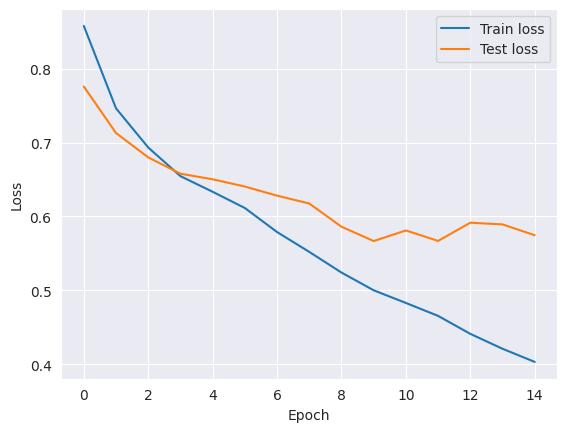

In [ ]:
plt.plot(ftext_history.history['loss'], label='Train loss')
plt.plot(ftext_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [ ]:
predictions = ftext.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

101/101 [==============================] - 30s 277ms/step
              precision    recall  f1-score   support

    positive       0.84      0.70      0.77       965
    negative       0.57      0.53      0.55       439
     neutral       0.79      0.87      0.83      1803

    accuracy                           0.77      3207
   macro avg       0.73      0.70      0.71      3207
weighted avg       0.77      0.77      0.77      3207

